In [185]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import random
import statsmodels.api as sm
from statsmodels import regression
from scipy.stats import linregress

warnings.filterwarnings('ignore')
import math

In [186]:
data = pd.read_csv('Data_PCLab1_Stock.csv')

In [187]:
# convert data into datetime format
data['Date'] = pd.to_datetime(data['Date'])

# set date as index
data.set_index('Date', inplace=True)


In [188]:
data.head()

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
Date,,,,,,,,,
2012-01-12,60.198570,75.510002,30.120001,12.13,175.929993,180.550003,28.250000,313.644379,1295.500000
2012-01-13,59.972858,74.599998,30.070000,12.35,178.419998,179.160004,22.790001,311.328064,1289.089966
2012-01-17,60.671429,75.239998,30.250000,12.25,181.660004,180.000000,26.600000,313.116364,1293.670044
2012-01-18,61.301430,75.059998,30.330000,12.73,189.440002,181.070007,26.809999,315.273285,1308.040039
2012-01-19,61.107143,75.559998,30.420000,12.80,194.449997,180.520004,26.760000,318.590851,1314.500000


# Task 1

## Correlation with S&P500

In [189]:
# compute the daily returns
def daily_returns(df):
    return df.pct_change(1)

# create the df
df_daily_returns = daily_returns(data)
df_daily_returns.head()

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
Date,,,,,,,,,
2012-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-13,-0.003749,-0.012051,-0.001660,0.018137,0.014153,-0.007699,-0.193274,-0.007385,-0.004948
2012-01-17,0.011648,0.008579,0.005986,-0.008097,0.018159,0.004689,0.167179,0.005744,0.003553
2012-01-18,0.010384,-0.002392,0.002645,0.039184,0.042827,0.005944,0.007895,0.006889,0.011108
2012-01-19,-0.003169,0.006661,0.002967,0.005499,0.026446,-0.003038,-0.001865,0.010523,0.004939


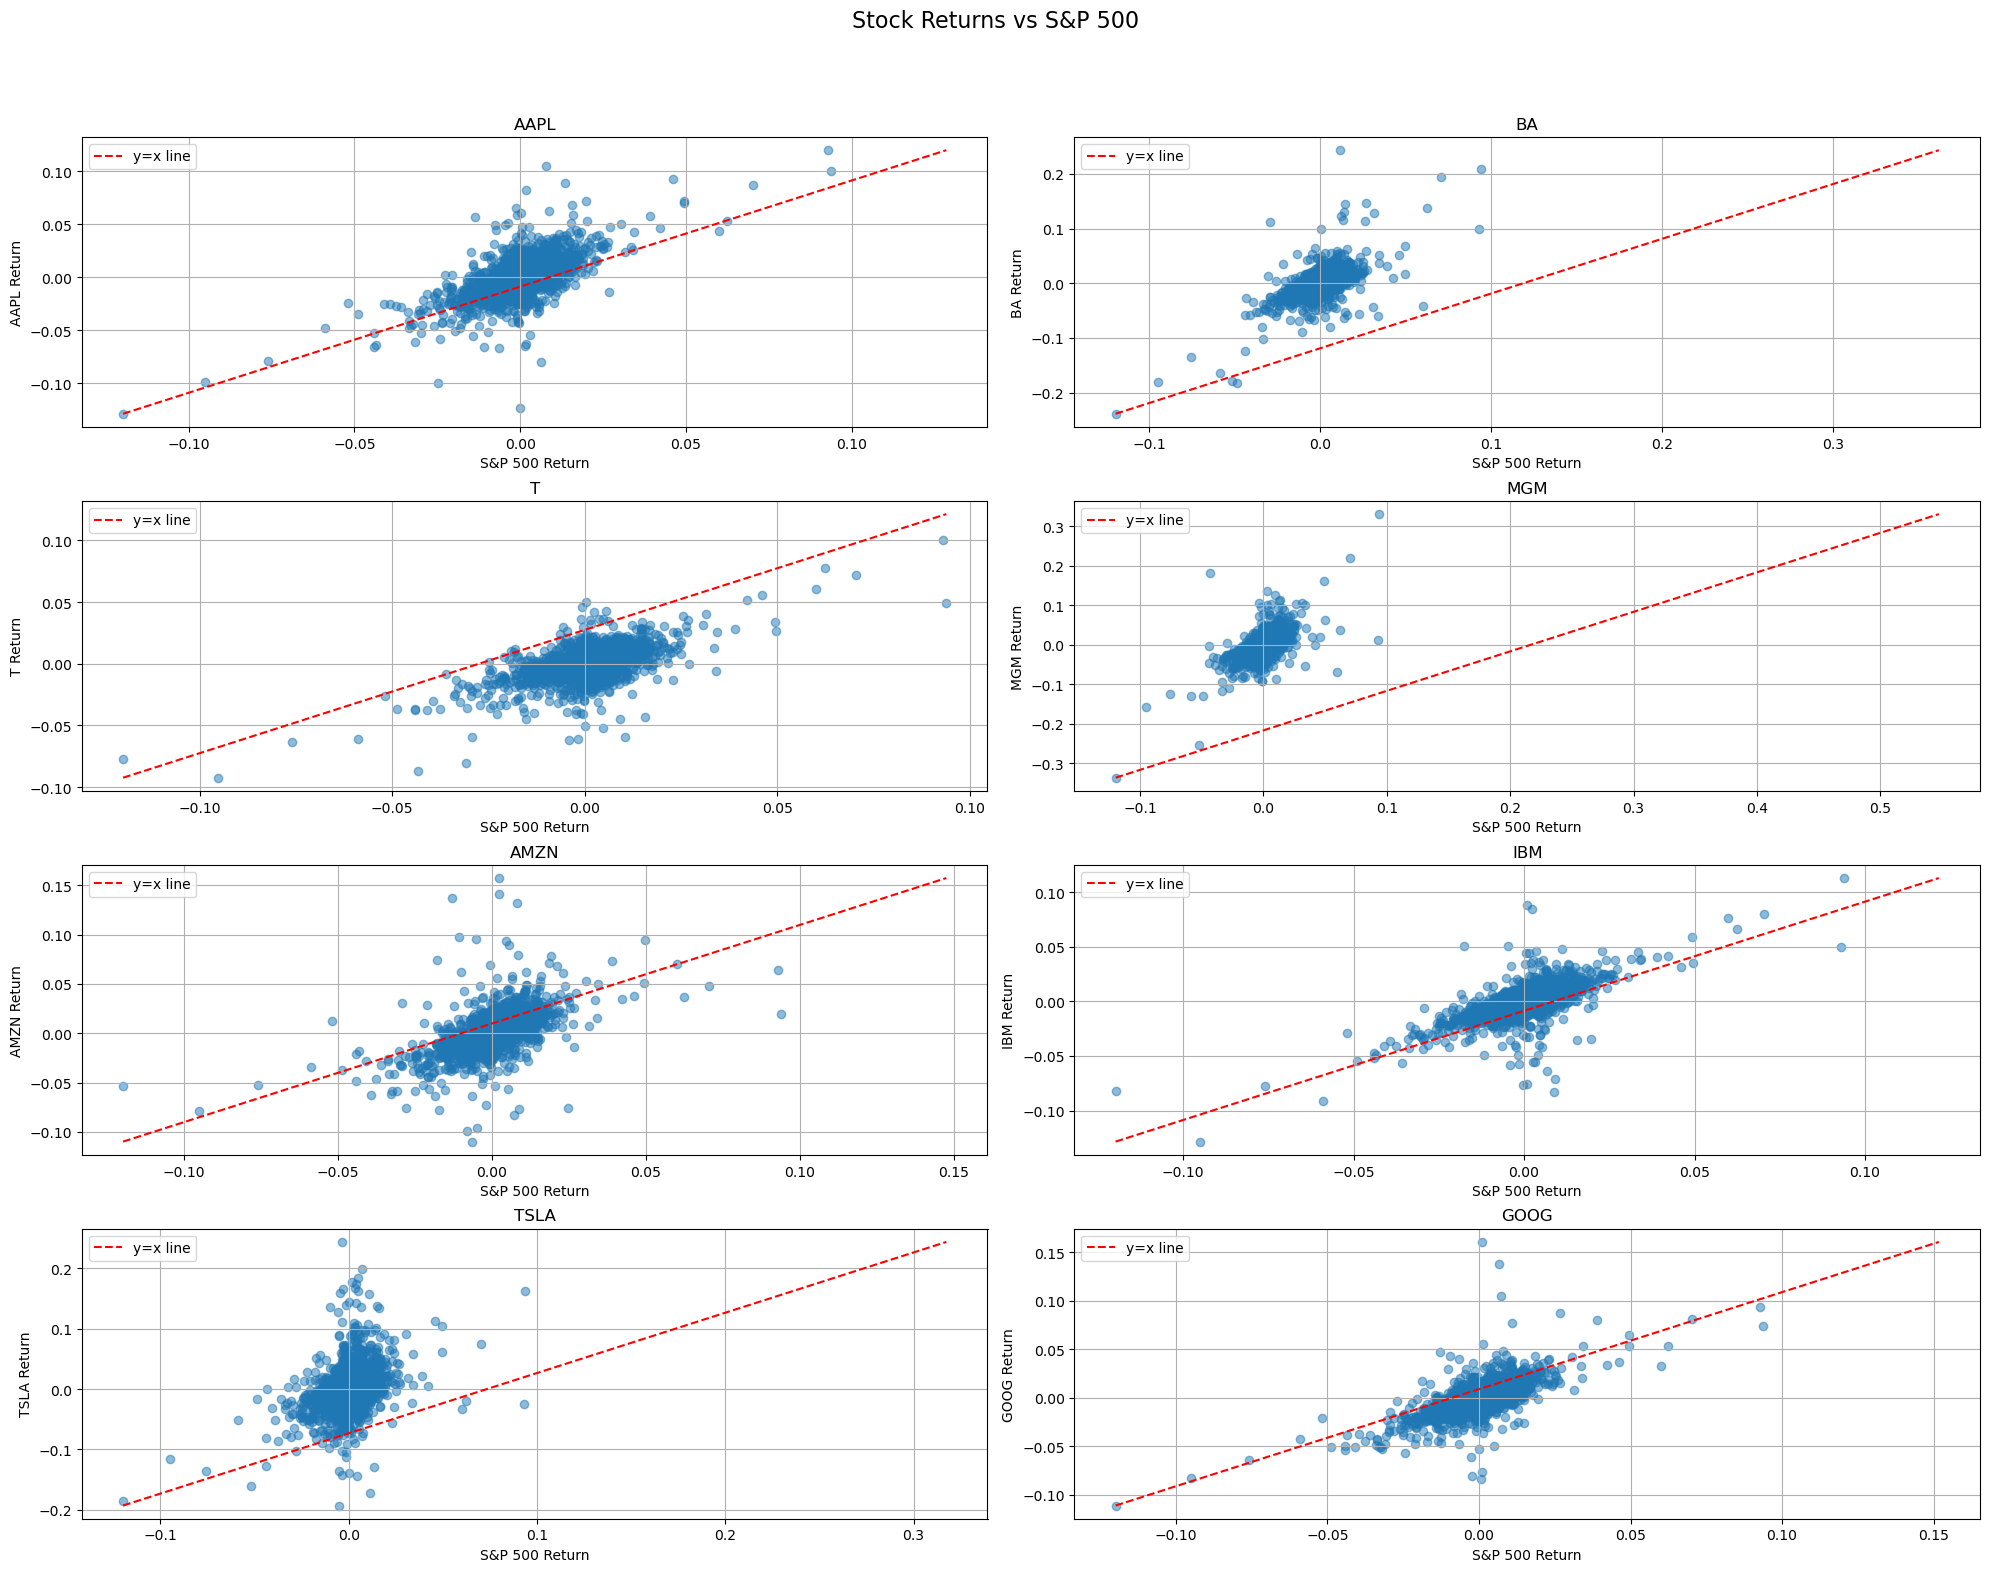

In [190]:
stocks = ['AAPL', 'BA', 'T', 'MGM', 'AMZN', 'IBM', 'TSLA', 'GOOG']

# Creating subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 16))
fig.suptitle('Stock Returns vs S&P 500', fontsize=16)

# Looping through each stock and creating scatterplots
for i, stock in enumerate(stocks):
    row = i // 2
    col = i % 2
    ax = axes[row][col]
    
    # Creating a scatterplot of the stock's return vs. S&P 500 return
    ax.scatter(df_daily_returns['sp500'], df_daily_returns[stock], alpha=0.5)
    
    # Plotting y=x line
    x_min, x_max = df_daily_returns['sp500'].min(), df_daily_returns['sp500'].max()
    y_min, y_max = df_daily_returns[stock].min(), df_daily_returns[stock].max()
    max_range = max(x_max - x_min, y_max - y_min)
    ax.plot([x_min, x_min + max_range], [y_min, y_min + max_range], color='red', linestyle='--', label='y=x line')
    
    ax.set_title(stock)
    ax.set_xlabel('S&P 500 Return')
    ax.set_ylabel(f'{stock} Return')
    ax.grid(True)
    ax.legend()

# Adjust subplot spacing
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the plots
plt.show()


In the presented graph the red dashed line represents the y = x line. Stocks with a strong correlation with the S&P 500 will have points that are closely clustered around this line. 

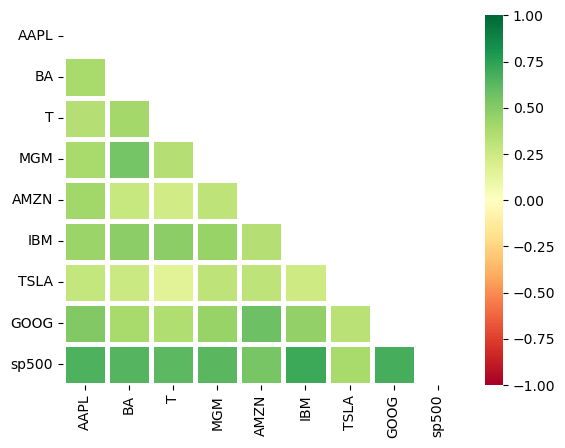

Stocks ordered by correlation with S&P500: 
IBM     0.703935
GOOG    0.684571
AAPL    0.657320
BA      0.641826
MGM     0.631449
T       0.617463
AMZN    0.539560
TSLA    0.387920
Name: sp500, dtype: float64


In [191]:
corr_df = df_daily_returns.corr(method='pearson')

#take the bottom triangle since it repeats itself
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
#generate plot
sns.heatmap(corr_df, cmap='RdYlGn', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

# display the stocks more correlated with sp500
print('Stocks ordered by correlation with S&P500: ')

print(df_daily_returns.corr()['sp500'].sort_values(ascending=False)[1:])

IBM, Google and Apple appear to have the strongest correlation among the considered stocks with respect to the S&P 500. In general all the stocks are positively correlated with the market but such medium-high coefficients may depend on various factors, such as the market capitalization of the company, industry sector and so on.

# Task 2

### CAPM model: OLS regression

Time to find the beta and alpha coefficient for each stock! We will use the CAPM model to do so. 

The formula for the CAPM model is the following:



First we create the function to find the results of the OLS regression between the daily returns of the considered stock and the daily returns of the S&P 500. 

The function returns also the p-values both for the alpha and beta coefficients. 



In [192]:
def linreg(x,y):
        X1 = sm.add_constant(x)
        model = regression.linear_model.OLS(y,X1)
        results = model.fit()

        # we collect both the values for alpha and beta and their p-values to check statistical significance
        return results.params[0], results.params[1],f'{results.pvalues[0]: .5f}', f'{results.pvalues[1]: .5f}'

In [193]:
# we first create a dictionary to collect the results
results_dict = {}

# we loop through each stock
for stock in stocks:
    
    # Regression model
    X = df_daily_returns['sp500'].values[1:] # since we assume the risk free to be 0, our X is just the market return
    Y = df_daily_returns[stock].values[1:] # for the same reason our target is just the stock return

    alpha, beta, pvalue_alpha, pvalue_beta = linreg(X,Y)
    results_dict[stock] = [alpha, beta, pvalue_alpha, pvalue_beta]

# now we create a dataframe with the results
df_reg_results = pd.DataFrame(results_dict, index=['alpha', 'beta', 'pvalue_alpha', "pvalue_beta"]).T

df_reg_results

,alpha,beta,pvalue_alpha,pvalue_beta
AAPL,0.000528,1.112891,0.06720,0.00000
BA,-0.000023,1.382867,0.95110,0.00000
T,-0.000286,0.74463,0.18294,0.00000
MGM,-0.000169,1.653568,0.71299,0.00000
AMZN,0.001023,0.991732,0.00351,0.00000
IBM,-0.000535,0.960416,0.01475,0.00000
TSLA,0.001759,1.268611,0.00992,0.00000
GOOG,0.000334,1.034881,0.18065,0.00000


For every stock we observed a positive beta coefficient, meaning that no stock is less risky than the market. This is a reasonable result since we are considering only stocks that are part of the S&P 500 index, which is a market index that includes the 500 largest companies in the United States.

Moreover some values are around one (e.g. IBM, Google, Apple), meaning these stocks tend to move in sync with the market. 
At the same times there are also stocks that more volatile than the market as demonstrated by some beta values greater than one.

### Statistical significance 

As for the statistical significance we observe that all the p-values are 0 for the beta values, meaning that we can reject the null hypothesis that the beta coefficient is equal to zero.

On the other hand, the p-values for the alpha coefficients are NOT all greater than 0.05, meaning that the alpha coefficient is not statistically equal to zero, at least for some stocks. 

### Plot of the alpha and betas

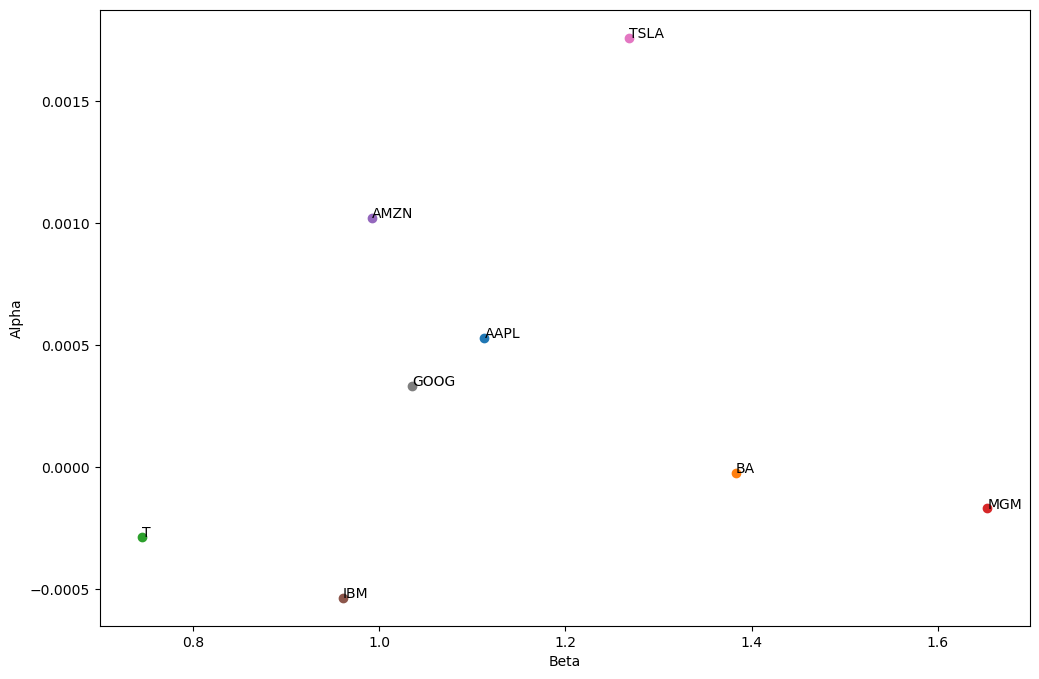

In [194]:
# plot all the alhpa and beta values
plt.figure(figsize=(12,8))
for stock in results_dict:
    plt.scatter(results_dict[stock][1], results_dict[stock][0], label=stock)
plt.xlabel('Beta')
plt.ylabel('Alpha')
# show the name of the stocks above the dots
for stock in results_dict:
    plt.annotate(stock, (results_dict[stock][1], results_dict[stock][0]))
plt.show();


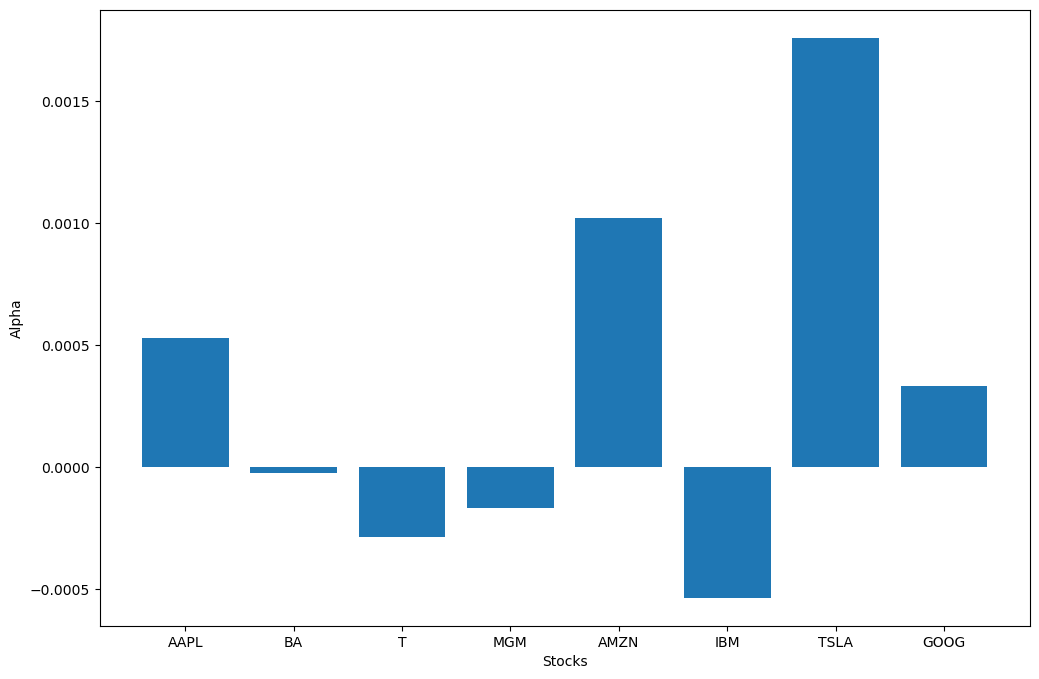

In [195]:
# plot the alpha values using a barplot
plt.figure(figsize=(12,8))
plt.bar(results_dict.keys(), [results_dict[stock][0] for stock in results_dict])
plt.xlabel('Stocks')
plt.ylabel('Alpha')
plt.show();

Tesla and Amazon have the highest alpha coefficients, meaning that they are the stocks that have the highest excess return with respect to the market. These stocks have exibited risk-adjusted excess returns that are statistically significant, outperforming the expected return implied by their risk (beta) in relation to the market. 

On the other hand, the alpha coefficient of IBM is negative and significantly not equally to zero, so it has underperformed the its expected return implied by its risk. 

### Extra analysis on alpha coefficients
! maybe check if the alpha different from 0 is persistent over time or if they are short term fluctuations. 

In [196]:
tesla_returns = df_daily_returns['TSLA'].values[1:]
sp500_returns = df_daily_returns['sp500'].values[1:]

# compute alpha on a time window of 30 days
def rolling_param(x,y, window=30):
    alpha_list = []
    for i in range(len(x)-window):
        alpha, beta, pvalue_alpha, pvalue_beta = linreg(x[i:i+window], y[i:i+window])
        alpha_list.append(alpha)
    
    return alpha_list

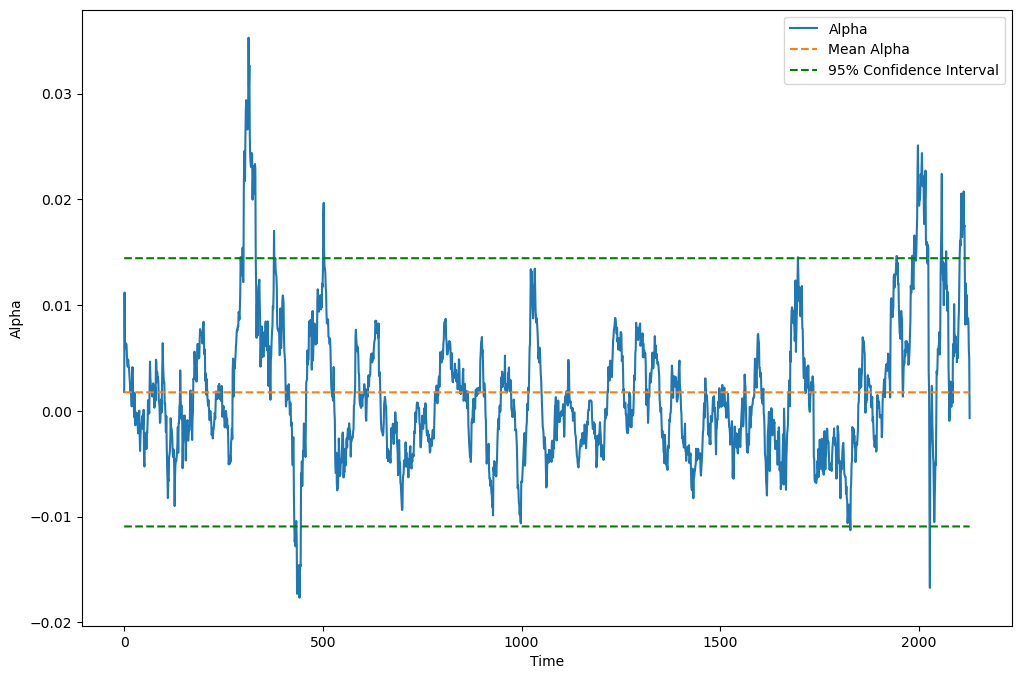

In [197]:
# plot the alpha list and the mean of the alpha list
plt.figure(figsize=(12,8))
plt.plot(rolling_param(sp500_returns, tesla_returns), label='Alpha')
plt.plot(np.mean(rolling_param(sp500_returns, tesla_returns))*np.ones(len(rolling_param(sp500_returns, tesla_returns))), label='Mean Alpha',  linestyle='--')
# add the 95% confidence interval
plt.plot(np.mean(rolling_param(sp500_returns, tesla_returns))*np.ones(len(rolling_param(sp500_returns, tesla_returns)))+1.96*np.std(rolling_param(sp500_returns, tesla_returns))*np.ones(len(rolling_param(sp500_returns, tesla_returns))), label='95% Confidence Interval', linestyle='--', color='green')
plt.plot(np.mean(rolling_param(sp500_returns, tesla_returns))*np.ones(len(rolling_param(sp500_returns, tesla_returns)))-1.96*np.std(rolling_param(sp500_returns, tesla_returns))*np.ones(len(rolling_param(sp500_returns, tesla_returns))), linestyle='--', color='green')
plt.xlabel('Time')
plt.ylabel('Alpha')
plt.legend()
plt.show();


The above graph shows that alpha is significantly different from zero only temporary, indeed it is almost always in the 95% confidence interval. 

Since the window is 30 days, we can conclude that the alpha different from 0 is not persistent over time and it is just a short term fluctuation.

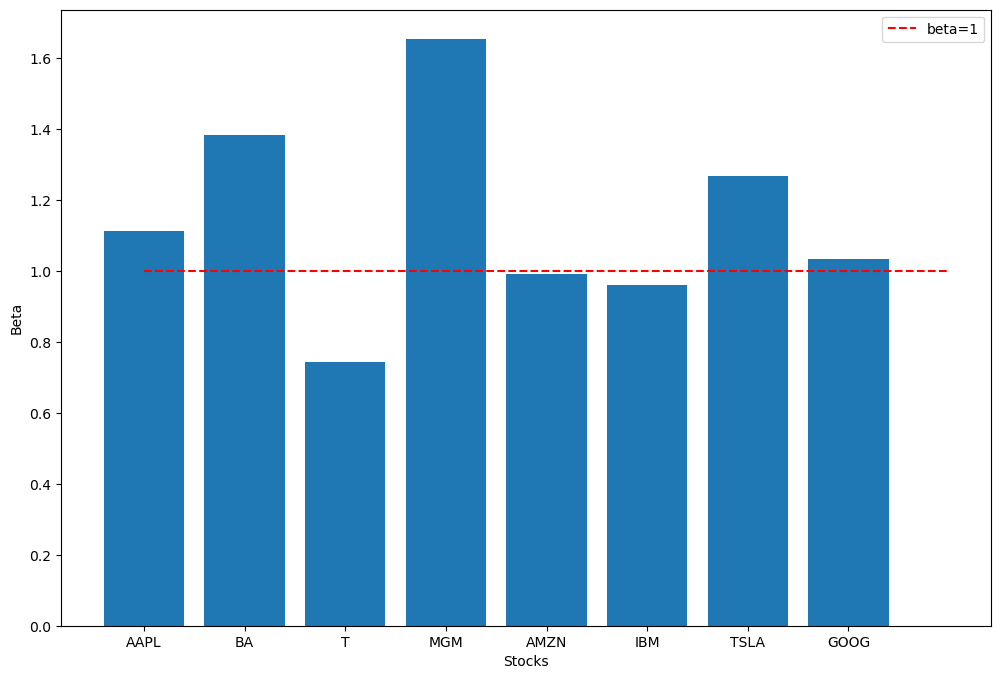

In [198]:
# plot the alpha values using a barplot
plt.figure(figsize=(12,8))
plt.bar(results_dict.keys(), [results_dict[stock][1] for stock in results_dict])
plt.plot([0., 8.], [1., 1.], color='red', linestyle='--', label='beta=1') # beta = 1 threshold
plt.xlabel('Stocks')
plt.ylabel('Beta')
plt.legend()
plt.show();

MGM resort international shows the highest beta coefficient, meaning that it is more sensitive to the market movements compared to the broader market. This may be due to the fact that MGM is a company that operates in the hospitality and entertainment industry, which has been heavily affected by the COVID-19 pandemic.
The gaming sector tends to go very well when economic conditions are favorable and people have more money to spend, but it is also very sensitive to economic downturns.

The low beta coefficient of AT&T may be explained by the fact that it operates in the telecommunications sector, which is typically a stable sector, in which the demand tends to be consistent regardless of the economic conditions.

### Compute and plot the residuals

In [199]:
# set risk free rate average to 0 (assumption)
rf = 0

In [200]:
# compute expected (daily) returns for each stock
exp_returns = {}
for stock in results_dict.keys():
    beta = results_dict[stock][1]
    alpha = results_dict[stock][0]
    # yearly expected return
    exp_returns[stock] = (rf + alpha + beta * (df_daily_returns['sp500'] - rf))      # CAPM formula

# transform the dictionary into a dataframe
df_exp_daily_returns = pd.DataFrame(exp_returns)

In [201]:
# compute error terms for each stock
error_terms = {}
for stock in results_dict.keys():
    # daily returns - expected daily returns
    error_terms[stock] = df_daily_returns[stock] - df_exp_daily_returns[stock]
# transform the dictionary into a dataframe
df_error_terms = pd.DataFrame(error_terms)

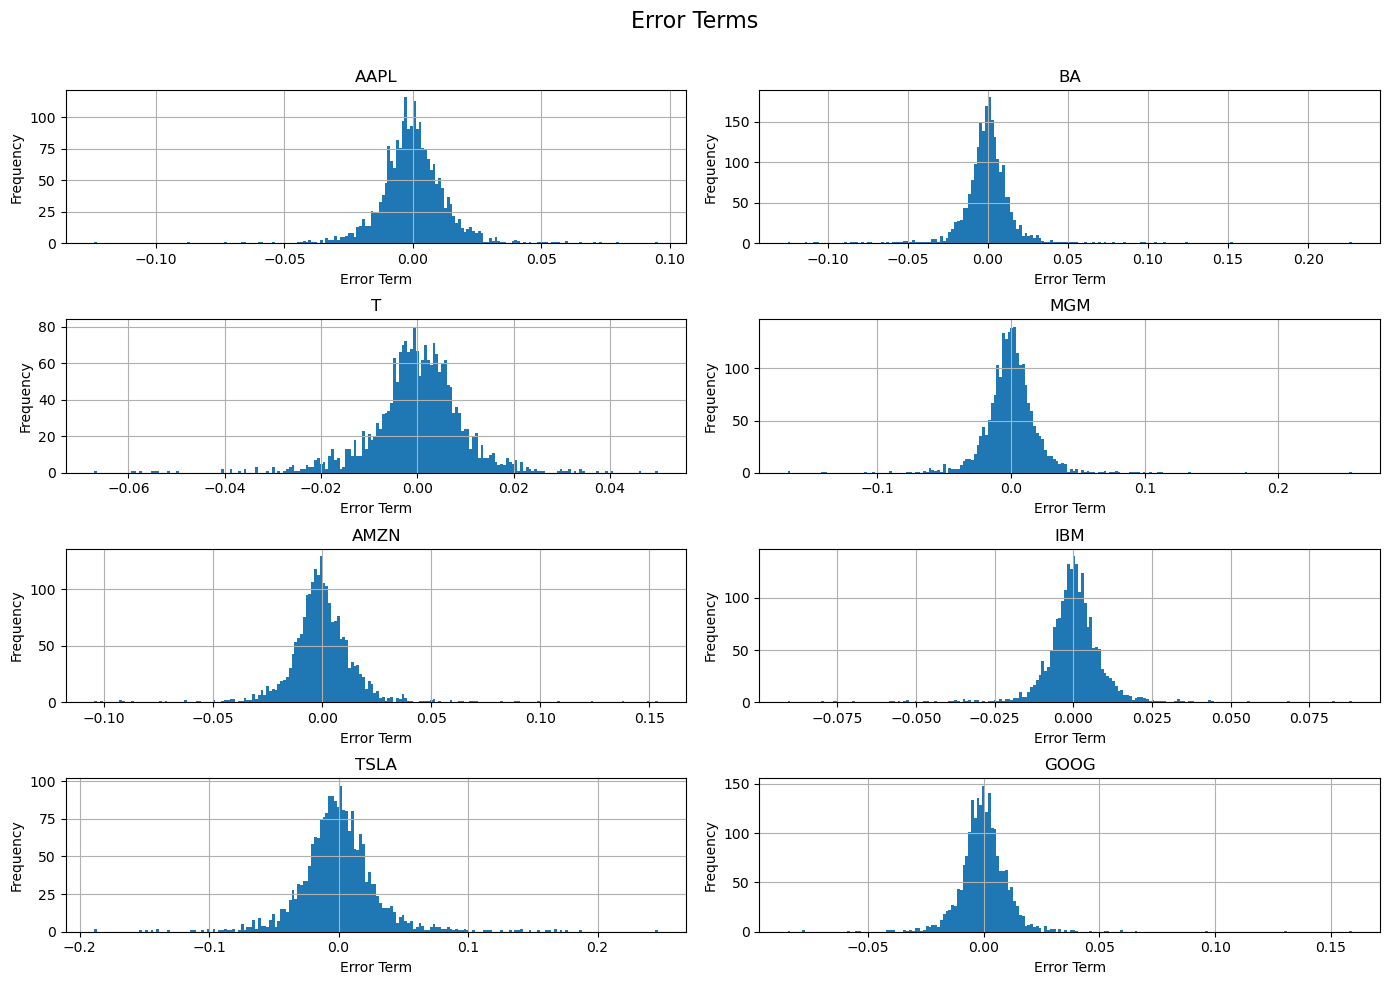

In [202]:
# plot the error terms in an histogram for each stock using subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 10))
fig.suptitle('Error Terms', fontsize=16)
for i, stock in enumerate(error_terms.keys()):
    row = i // 2
    col = i % 2
    ax = axes[row][col]
    ax.hist(error_terms[stock], bins=200)
    ax.set_title(stock)
    ax.set_xlabel('Error Term')
    ax.set_ylabel('Frequency')
    ax.grid(True)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show();

In [203]:
df_error_terms.head()

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG
Date,,,,,,,,
2012-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-13,0.001229,-0.005186,0.002310,0.026488,0.018038,-0.002412,-0.188756,-0.002598
2012-01-17,0.007166,0.003689,0.003626,-0.013803,0.013613,0.001811,0.160912,0.001734
2012-01-18,-0.002506,-0.017730,-0.005341,0.020985,0.030789,-0.004189,-0.007956,-0.004941
2012-01-19,-0.009194,-0.000145,-0.000424,-0.002499,0.020526,-0.007246,-0.009889,0.005078


Now we check if the distribution of the error terms is normal using the Q-plot

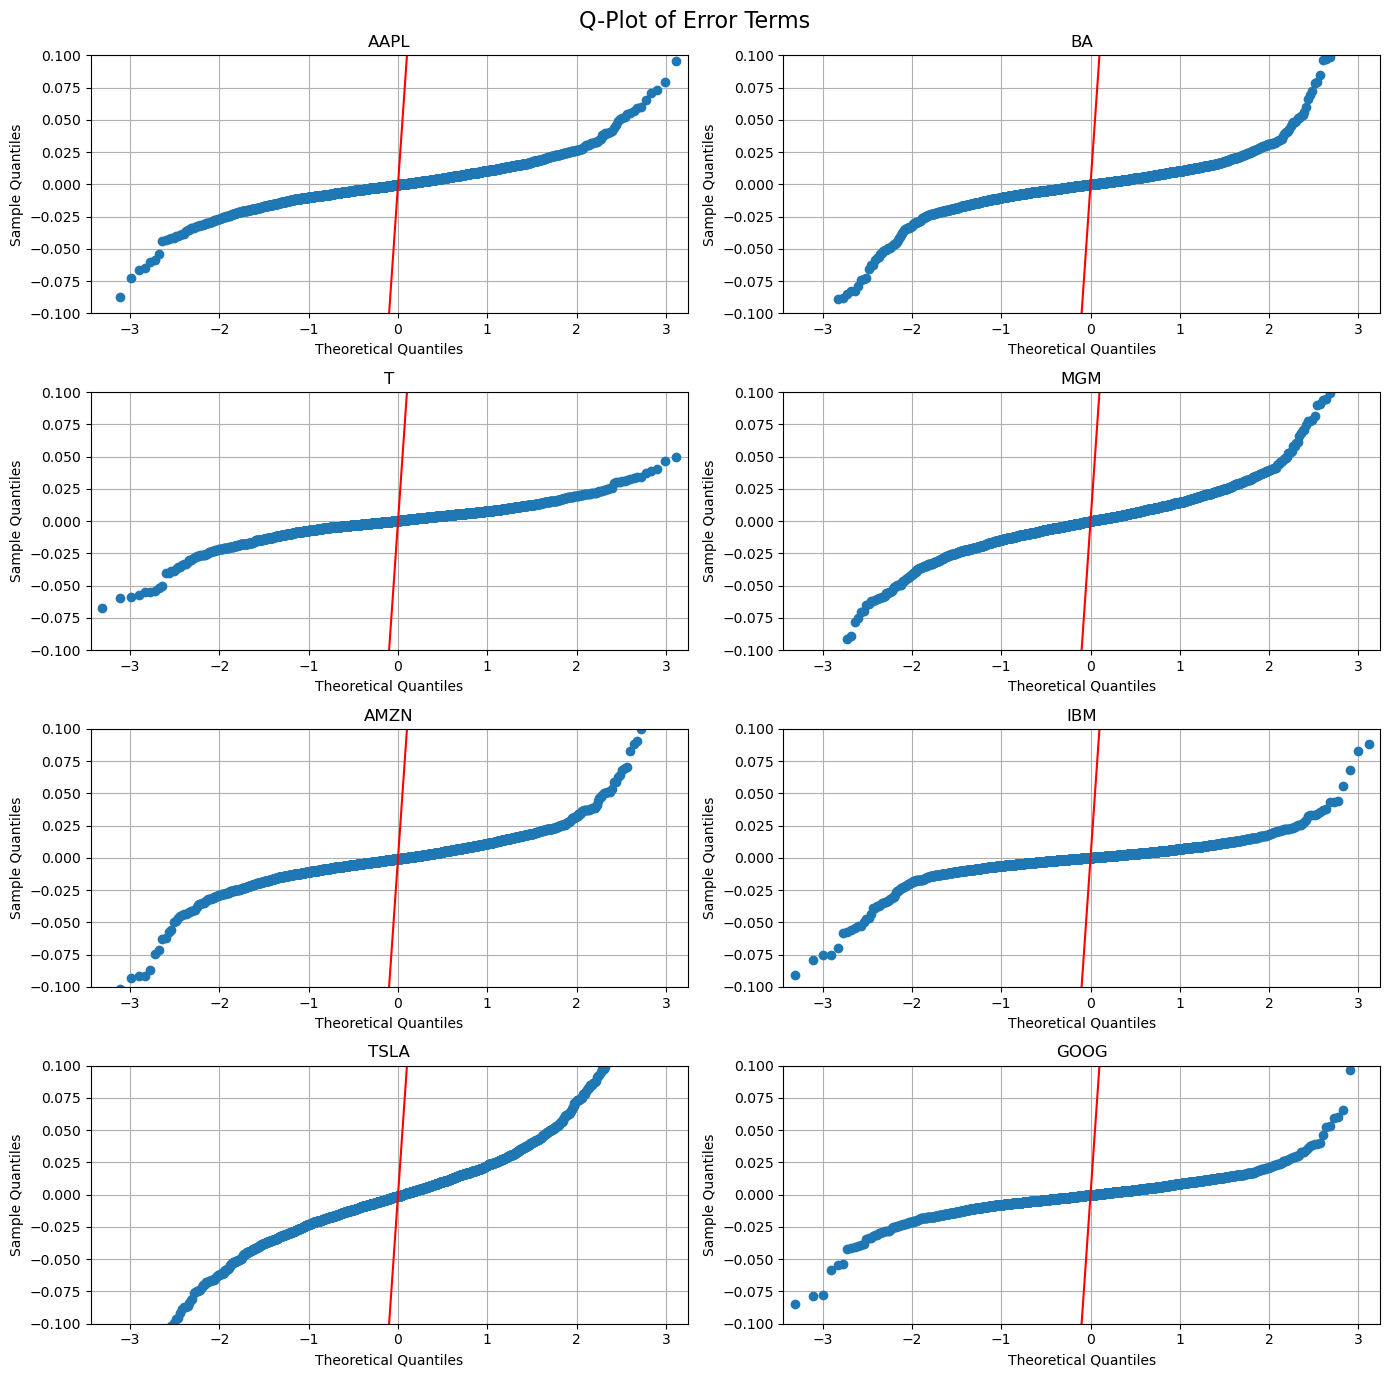

In [204]:
# for each stock plot the Q-plot of the error terms
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 14))
fig.suptitle('Q-Plot of Error Terms', fontsize=16)
for i, stock in enumerate(error_terms.keys()):
    row = i // 2
    col = i % 2
    ax = axes[row][col]
    sm.qqplot(df_error_terms[stock], line='45', ax=ax)
    ax.set_ylim(-0.1, 0.1)
    ax.set_title(stock)
    ax.grid(True)
plt.tight_layout()
plt.show()

Since the dots of the plot do not fall along the red line, the error terms cannot be considered normally distributed.

The fact that the CAPM errors are not normally distributed may suggest CAPM is not an adequate model to explain the returns of the considered stocks. The financial markets might incorporate some form of non-normality and heteroscadasticity (changing volatility over time) which is not captured by the CAPM model.

Our idea is that the CAPM relies on several assumptions, including the normal distribution of asset returns, which was shown to be not true in the previous assignment.

### Portfolio with 4 most risky stocks

First we compute the expected yearly returns. How?

We use the alpha and beta coefficients computed before over the whole time period. 

Then we compute the expected yearly returns for each stock using the following formula:

$$
E[R_i] = \beta_i E[R_m]
$$

where $E[R_m]$ is the expected return of the market, which we assume to be equal to the average yearly return of the S&P 500 index over the considered time period.



In [205]:
rf = 0
# compute market risk premium = average market return - rf
rm = df_daily_returns['sp500'].mean()*252

# compute expected (annual) returns for each stock
exp_yearly_returns = {}
for stock in results_dict.keys():
    beta = results_dict[stock][1]
    alpha = results_dict[stock][0]
    # yearly expected return
    exp_yearly_returns[stock] = (rf + alpha + beta * (rm - rf))     # CAPM formula

# transform the dictionary into a dataframe
df_exp_yearly_returns = pd.DataFrame(exp_yearly_returns, index=['Expected_Yearly_Return']).T

Let's find the 4 most risky stocks with respect to the market.

In [206]:
# sort the results_dict based on the beta values in decreasnig order
sorted_results_dict = dict(sorted(results_dict.items(), key=lambda item: item[1][1], reverse=True))
# select the 4 riskiest stocks
riskiest_stocks = list(sorted_results_dict.keys())[:4]
print(riskiest_stocks)

['MGM', 'BA', 'TSLA', 'AAPL']


Important to notice that the beta coefficient is not a measure of the volatility of the stock, but rather the volatility of the stock in relation to the market.

In [207]:
# order by std deviation in descending order
df_daily_returns.std().sort_values(ascending=False)

TSLA     0.034308
MGM      0.027472
BA       0.022603
AMZN     0.019283
AAPL     0.017762
GOOG     0.015859
IBM      0.014313
T        0.012651
sp500    0.010491
dtype: float64

Then we compute the expected yearly return of the portfolio as the weighted average of the expected yearly returns of the stocks in the portfolio.

This is the formula:

$$
E[R_p] = \sum_{i=1}^{n} w_i E[R_i]
$$

where $w_i$ is the weight of the $i$-th stock in the portfolio and $n$ is the number of stocks in the portfolio.

In [208]:
# filter the expected returns of the riskiest stocks
portfolio_returns = df_exp_yearly_returns.loc[riskiest_stocks]

print(portfolio_returns.head())
print('\n')

# compute daily average returns of the portfolio with equal weights
exp_portfolio_return = portfolio_returns.mean()[0]

print(f'Expected return of the portfolio with equal weights: {exp_portfolio_return: .5f}')

      Expected_Yearly_Return
MGM                 0.205426
BA                  0.171914
TSLA                0.159491
AAPL                0.138899


Expected return of the portfolio with equal weights:  0.16893


The return we found is based on the beta computed along the time period 2012-2020.
It's important to notice that this portfolio might not be also the most performant in the same time window for a couple of reasons:
- **market direction**: high beta stocks tend to move more than the market in BOTH directions. if there are periods of market downturn, the portfolio will suffer more than the market.

- **idiosyncratic risk**: the portfolio is not diversified, so it is exposed to the idiosyncratic risk of the stocks in the portfolio. If one of the stocks in the portfolio has a bad performance, the portfolio will suffer more than the market. Having only 4 stocks in the portfolio doesn't eliminate the idiosyncratic risk completely.

- Considering the average beta over the whole period makes you lose some useful information about how the risk of the stocks with respect to the market has changed over time.

### Extra: simulation of random portfolios and comparison

We proceed by simulating some random (equally weighted) portfolios with 4 stocks chosen at random among the pool of 8 available stocks in the dataset.

It's clear that the possible portfolios are only 70 (8 choose 4), so we can simulate all of them and compare them with the portfolio we found before.

$$
\frac{8!}{4!(8-4)!} = 70
$$

Anyway we decided to simulate over 100 portfolio just to be sure to have all the possible combinations included.

In [209]:
# we pick the daily returns of only the riskiest stocks
riskiest_portfolio = df_daily_returns[riskiest_stocks][1:]

# we average across the 4 to get the portfolio return
riskiest_portfolio['port_daily_ret'] = riskiest_portfolio.mean(axis=1)

# transform the daily returns into yearly returns
riskiest_portfolio = riskiest_portfolio.groupby(riskiest_portfolio.index.year).mean()*252

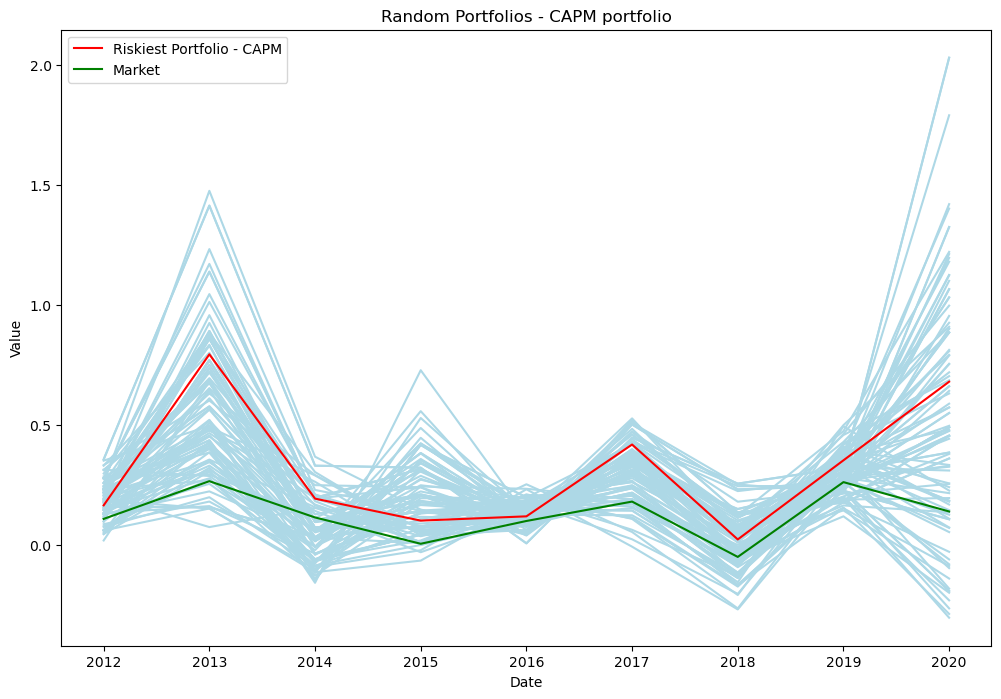

In [210]:
# simulate 1000 portfolios with 4 random stocks with equal weights

random.seed(1)
plt.figure(figsize=(12,8))
for i in range(100):
    # take 4 random stocks
    random_stocks = np.random.choice(list(sorted_results_dict.keys()), 4)
    # take the returns of the random stocks
    random_portfolio = df_daily_returns[random_stocks]
    # compute the average return of the portfolio
    random_portfolio['mean'] = random_portfolio.mean(axis=1)
    random_portfolio = random_portfolio.groupby(random_portfolio.index.year).mean()*252
    # plot the returns of the portfolio
    plt.plot(random_portfolio['mean'], color = 'lightblue')
    
# plot the returns of the riskiest portfolio build using CAPM 
plt.plot(riskiest_portfolio['port_daily_ret'], color='red', label='Riskiest Portfolio - CAPM')
plt.plot(df_daily_returns['sp500'].groupby(df_daily_returns.index.year).mean()*252, color='green', label='Market')
plt.title('Random Portfolios - CAPM portfolio')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show();

As we can observe from the graph every year there is a portfolio that outperforms the portfolio we found before, but overall the portoflio has good returns. The thing that we expected and it is confirmed is that, by picking 4 stocks with high value of beta (>1) our portfolio always outperforms the market. At the same time when the market goes down our portfolio declines as well but often with greater magnitude.

# Task 3

Let's test the CAPM model predictions.

In [211]:
# add to the df_daily_returns a column representing the year just for simplicity
df_daily_returns['Year'] = df_daily_returns.index.year
# get the list of years in the dataset
years = df_daily_returns['Year'].unique()

1. we start from computing the value of the beta coefficient for each stock at the end of every year via the OLS regression.

In [212]:
# initialize a dictionary to store the results
betas = {}
# drop the first row with nan values
df_daily_returns = df_daily_returns[1:]

# for each year compute the beta of each stock
for year in years:
    # initialize a list to store the results of each stock
    results = []
    df = df_daily_returns[df_daily_returns['Year'] == year]
    for stock in stocks:
        # Regression model
        X = df['sp500'].values # since we assume the risk free to be 0, our X is just the market return
        Y = df[stock].values # for the same reason our target is just the stock return

        # function previously build to run the OLS regression
        alpha, beta, pvalue_alpha, pvalue_beta = linreg(X,Y)
        results.append(beta)
    betas[year] = results

# transform betas to df
betas_df = pd.DataFrame(betas, index=stocks).T

In [213]:
betas_df

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG
2012,1.283028,1.024616,0.616265,1.732747,1.123074,0.856619,1.611417,0.860334
2013,0.626566,0.966673,0.784543,1.526288,1.265466,0.765491,1.174505,0.945169
2014,0.835490,1.021059,0.564327,1.492332,1.463360,0.729346,1.900735,1.279824
2015,1.145075,0.999672,0.721119,1.479366,1.119326,1.019357,1.136643,1.084603
2016,1.009962,1.217194,0.476372,1.669338,1.116334,0.931592,1.215942,0.952996
2017,1.376087,0.997476,0.762074,1.439209,1.311298,0.664218,1.357621,1.263186
2018,1.255214,1.311227,0.659487,1.355182,1.623267,0.967147,1.378808,1.371131
2019,1.558167,0.981311,0.577960,1.336059,1.327099,1.075293,1.317051,1.290719
2020,1.070752,1.735518,0.875194,1.847119,0.605983,1.011492,1.143629,0.906244


2. Then we compute the average market return for each year and the associated market risk premium. In this example they are the same thing, since the considered risk-free rate is equal to zero. 

We add the computed values to the dataframe

In [214]:
# compute the average market return for each year
e_rms = []
for year in years:
    # append the average return of the market for each year
    e_rms.append(df_daily_returns[df_daily_returns['Year'] == year]['sp500'].mean())
betas_df['e_rm'] = e_rms

# set risk free rate average to 0 (assumption)
rf = 0
# compute market risk premium for each year (average market return - risk free rate)
betas_df['mrp'] = betas_df['e_rm'] - rf

betas_df

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,e_rm,mrp
2012,1.283028,1.024616,0.616265,1.732747,1.123074,0.856619,1.611417,0.860334,0.000430,0.000430
2013,0.626566,0.966673,0.784543,1.526288,1.265466,0.765491,1.174505,0.945169,0.001054,0.001054
2014,0.835490,1.021059,0.564327,1.492332,1.463360,0.729346,1.900735,1.279824,0.000454,0.000454
2015,1.145075,0.999672,0.721119,1.479366,1.119326,1.019357,1.136643,1.084603,0.000019,0.000019
2016,1.009962,1.217194,0.476372,1.669338,1.116334,0.931592,1.215942,0.952996,0.000395,0.000395
2017,1.376087,0.997476,0.762074,1.439209,1.311298,0.664218,1.357621,1.263186,0.000716,0.000716
2018,1.255214,1.311227,0.659487,1.355182,1.623267,0.967147,1.378808,1.371131,-0.000199,-0.000199
2019,1.558167,0.981311,0.577960,1.336059,1.327099,1.075293,1.317051,1.290719,0.001038,0.001038
2020,1.070752,1.735518,0.875194,1.847119,0.605983,1.011492,1.143629,0.906244,0.000553,0.000553


3. With the coefficients obtained before we are able to compute the expected annual returns of the stocks in the considered time period applying the capm formula. At the end of every year y the expected return of stock i is the beta of year y-1 times the market risk premium of year y.
The formula is the following:

$$
E[R_i] = \beta_{i,y-1} E[R_m]
$$





In [215]:
# create a function to compute the annualized average return of each stock
def annualized_average_return(df_betas, years, stocks):
    '''for each year computes the expected annual return of each stock
    using the beta calculated in the previous year'''
    
    returns = {}
    for year in years[1:]:
        results = []
        for stock in stocks:
            # select previous year beta of the specific stock
            beta = df_betas.loc[year-1, stock]
            # yearly expected return (rf + beta * mrp*252)
            results.append((rf + beta * df_betas.loc[year, 'mrp'])*252)
        
        returns[year] = results
    
    return returns

In [216]:
# compute the expected returns of each stock for each year
exp_returns = annualized_average_return(betas_df, years, stocks)
# transform the dictionary into a dataframe
df_expected_returns = pd.DataFrame(exp_returns, index=stocks).T

df_expected_returns

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG
2013,0.340683,0.272067,0.163637,0.460098,0.298211,0.227459,0.427881,0.228445
2014,0.071644,0.110534,0.089708,0.174523,0.144699,0.087530,0.134298,0.108075
2015,0.003908,0.004777,0.002640,0.006981,0.006846,0.003412,0.008892,0.005987
2016,0.114102,0.099613,0.071857,0.147413,0.111536,0.101575,0.113262,0.108076
2017,0.182271,0.219671,0.085973,0.301271,0.201469,0.168128,0.219445,0.171991
2018,-0.068969,-0.049993,-0.038195,-0.072133,-0.065722,-0.033290,-0.068044,-0.063311
2019,0.328349,0.343001,0.172514,0.354499,0.424627,0.252994,0.360680,0.358671
2020,0.216959,0.136638,0.080475,0.186033,0.184785,0.149724,0.183386,0.179720


4. Now that we have the expected returns from the CAPM model we proceed by computing the actual returns of the stocks in the considered time period by annualizing the daily returns. 

In [217]:
# compute annualized average return for each year for each stock in df_daily_returns
o_returns = {}
for year in years[1:]:
    results = []
    for stock in stocks:
        # select the average return of the specific stock for the specific year
        results.append(df_daily_returns[df_daily_returns['Year'] == year][stock].mean()*252)
    o_returns[year] = results

# transform the dictionary into a dataframe
df_observed_returns = pd.DataFrame(o_returns, index=stocks).T

df_observed_returns

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG
2013,0.094057,0.617045,0.054289,0.746903,0.500096,-0.003376,1.718407,0.483615
2014,0.343711,-0.030139,-0.035257,-0.048195,-0.197648,-0.141403,0.505964,-0.039032
2015,-0.011884,0.130017,0.036940,0.135428,0.833698,-0.130693,0.151116,0.410651
2016,0.122873,0.103335,0.222860,0.290248,0.147730,0.207081,-0.040560,0.036887
2017,0.396499,0.657706,-0.074753,0.178395,0.467804,-0.066717,0.440463,0.317646
2018,-0.029376,0.139141,-0.282077,-0.253648,0.316396,-0.269934,0.234861,0.029200
2019,0.656638,0.051926,0.331854,0.350760,0.233466,0.186048,0.350457,0.284456
2020,0.782204,-0.422194,-0.329690,-0.039994,0.919402,0.023305,2.400446,0.259907


5. We compute the errors and perform some analysis

In [218]:
# compute the error terms for each stock for each year
df_error_terms = df_observed_returns - df_expected_returns

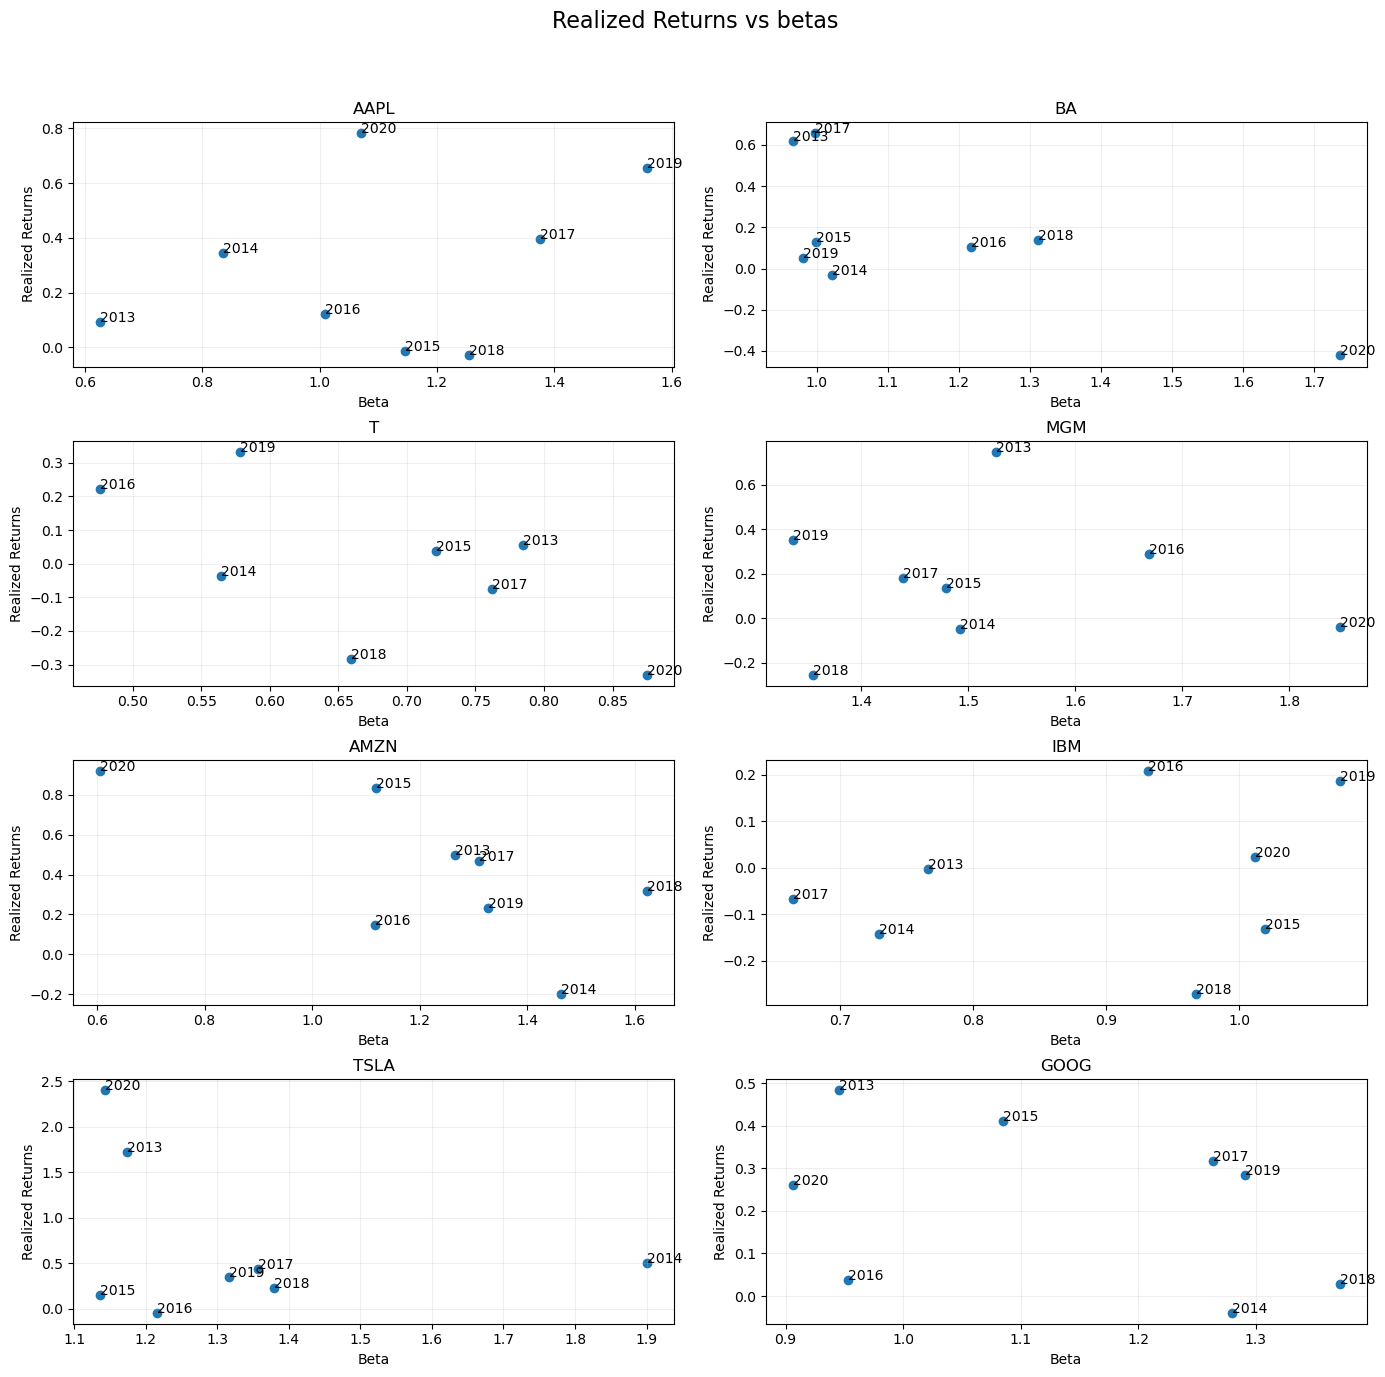

In [219]:
# plot the returns of each stock against the beta for each year
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 14))
fig.suptitle('Realized Returns vs betas', fontsize=16)

for i,stock in enumerate(stocks):
    ax = axes[i//2][i%2]
    ax.scatter(betas_df.loc[2013:,stock], df_observed_returns[stock])
    ax.set_title(stock)
    ax.set_xlabel('Beta')
    ax.set_ylabel('Realized Returns')
    ax.grid(True, alpha=0.2)
    for year in years[1:]:
        ax.annotate(year, (betas_df.loc[year, stock], df_observed_returns.loc[year, stock]))
    
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show();

For all the stocks we can see that there are some years in which the returns were higher with a corresponding lower beta. This highlights the fact that beta refers only to the risk of the stock with respect to the market, without considering the risk specific to each stock.

--> thus we may not use just the beta value of a stock to predict its future value 

Now we plot the annual performances of each stock comapring the realized returns and the returns obtained using CAPM

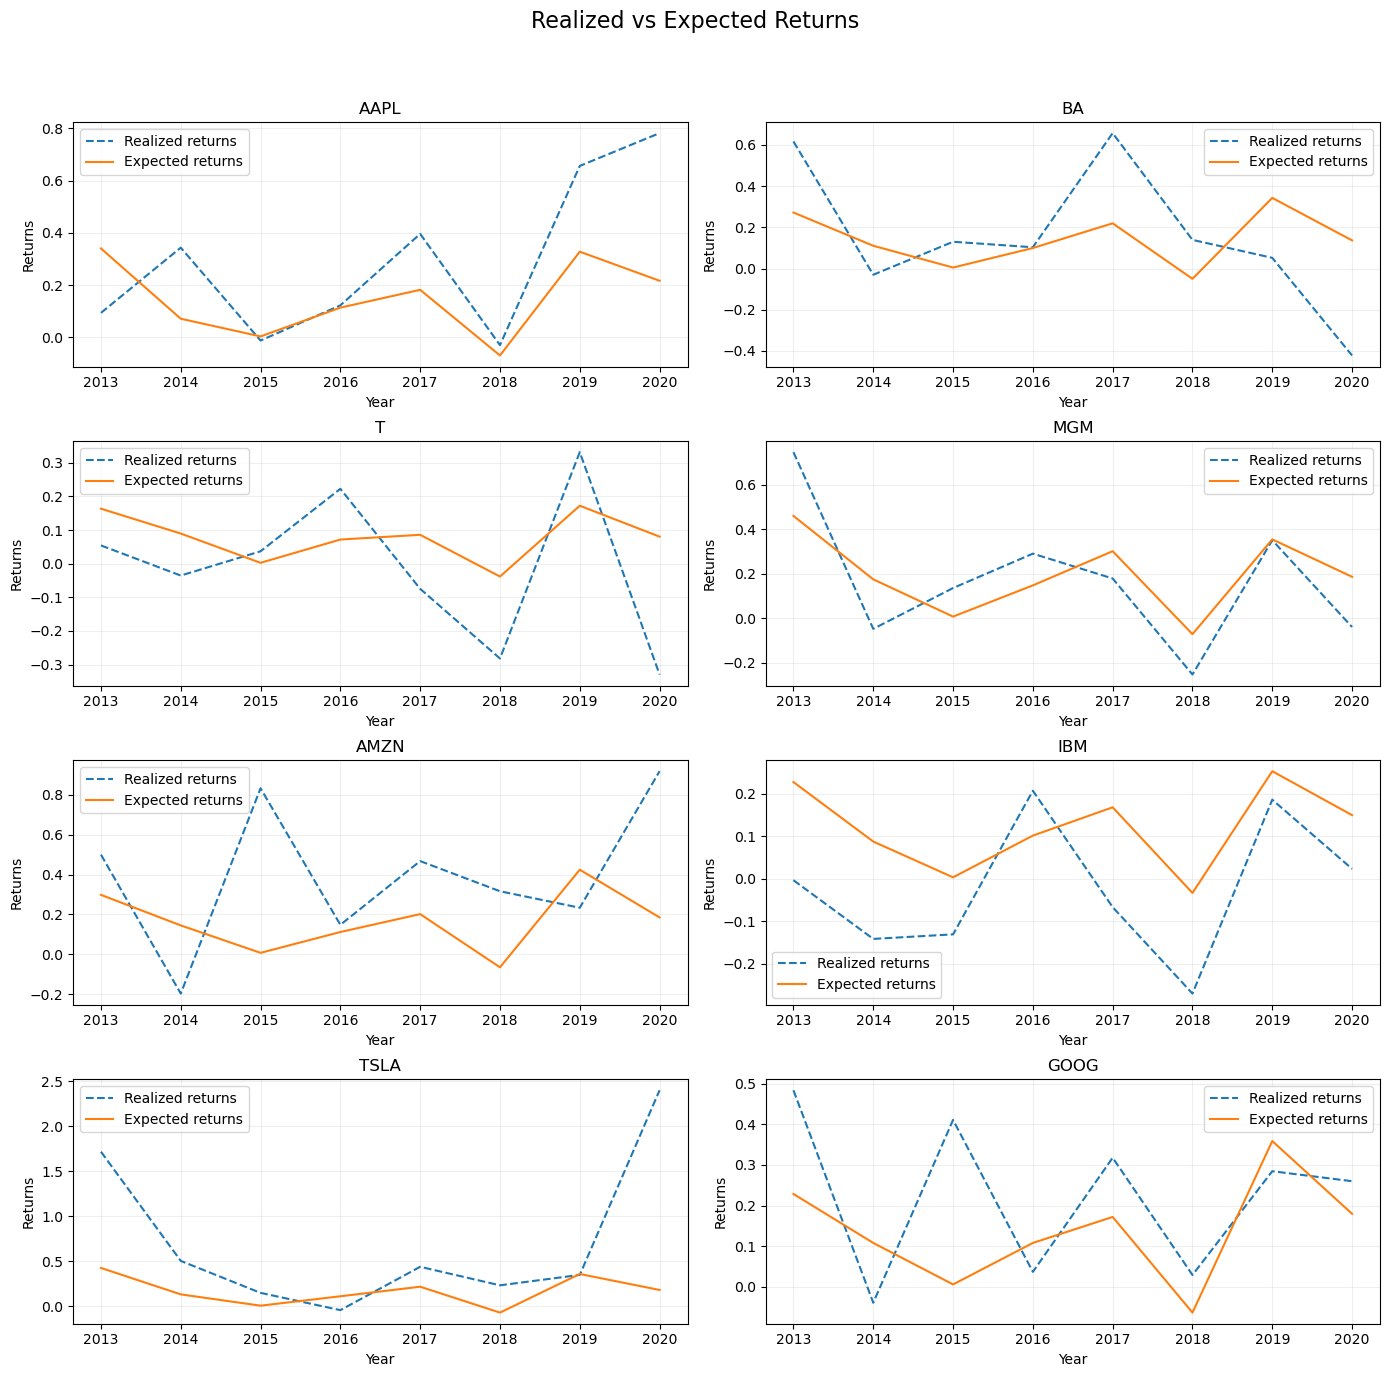

In [220]:
# plot observed returns vs expected returns for each stock
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 14))
fig.suptitle('Realized vs Expected Returns', fontsize=16)
for i,stock in enumerate(stocks):
    ax = axes[i//2][i%2]
    ax.plot(years[1:], df_observed_returns[stock], linestyle = '--', label='Realized returns')
    ax.plot(years[1:],df_expected_returns[stock], label='Expected returns')
    ax.set_title(stock)
    ax.set_xlabel('Year')
    ax.set_ylabel('Returns')
    ax.legend()
    ax.grid(True, alpha=0.2)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show();

Looking at the plots, it is possible to notice that the trend of the expected returns seem to be delayed by one year. This may be due to the fact that to compute these expected returns of year Y we used the beta values of the previous year Y-1 and the market premium of the year Y.
In addition, the expected returns changes seem to always be less steep than the changes in the realized returns.

# Task 4 

In [240]:
import yfinance as yf
URL = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
tickers = pd.read_html(URL)[0]['Symbol'].tolist()

In [241]:
tickers

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ATVI',
 'ADM',
 'ADBE',
 'ADP',
 'AES',
 'AFL',
 'A',
 'ABNB',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AMD',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BBWI',
 'BAX',
 'BDX',
 'WRB',
 'BRK.B',
 'BBY',
 'BIO',
 'TECH',
 'BIIB',
 'BLK',
 'BX',
 'BK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'BG',
 'CHRW',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'COR',
 'CNC',
 'CNP',
 'CDAY',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH'

In [242]:
# define start and end date
date1 = '2012-01-12'
date2 = '2020-08-12'

data_yf = yf.download(tickers, start=date1,end=date2)

data_yf.head()

[*********************100%%**********************]  503 of 503 completed


7 Failed downloads:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2012-01-12 -> 2020-08-12)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['ABNB', 'CEG', 'OGN', 'KVUE', 'GEHC']: Exception("%ticker%: Data doesn't exist for startDate = 1326344400, endDate = 1597204800")


Adj Close                                            \
                             A       AAL       AAPL ABBV ABNB        ABT   
Date                                                                       
2012-01-12 00:00:00  25.542433  5.703586  12.774086  NaN  NaN  21.086287   
2012-01-13 00:00:00  25.245121  5.628165  12.726187  NaN  NaN  21.189497   
2012-01-17 00:00:00  25.846203  5.543320  12.874426  NaN  NaN  21.296539   
2012-01-18 00:00:00  26.673485  5.694159  13.008110  NaN  NaN  21.162739   
2012-01-19 00:00:00  27.048349  5.901561  12.966879  NaN  NaN  21.189497   

                                                                 ...   Volume  \
                          ACGL        ACN       ADBE        ADI  ...     WYNN   
Date                                                             ...            
2012-01-12 00:00:00  12.403333  43.430714  29.230000  28.315735  ...  6974000   
2012-01-13 00:00:00  12.390000  42.875149  28.969999  27.792070  ...  2641400   
2012-01-17 00:00:00  12.313333  43.068398  29.350000  28.110828  ...  3459400   
2012-01-18 00:00:00  12.320000  44.243946  29.889999  29.712179  ...  2978200   
2012-01-19 00:00:00  12.296667  44.123165  30.240000  30.106819  ...  2153600   

                                                                            \
                         XEL       XOM     XRAY      XYL      YUM      ZBH   
Date                                                                         
2012-01-12 00:00:00  3898800  17357200   701000   709300  4792691  1604122   
2012-01-13 00:00:00  3162300  15551600   524600   886200  5074646  1077689   
2012-01-17 00:00:00  3646100  15627900   695800   465400  4190805  1495869   
2012-01-18 00:00:00  2197000  16754200  1102500  1453700  5246852  1347961   
2012-01-19 00:00:00  2522800  16383500  1558000   838000  5009687  1873467   

                                          
                       ZBRA     ZION ZTS  
Date                                      
2012-01-12 00:00:00  190700  3832200 NaN  
2012-01-13 00:00:00  190300  2305200 NaN  
2012-01-17 00:00:00   95100  2545600 NaN  
2012-01-18 00:00:00   86400  3065800 NaN  
2012-01-19 00:00:00  132700  3132900 NaN  

[5 rows x 3018 columns]

In [243]:
# show unique tickers
num_tickers = len(data_yf.columns.get_level_values(1).unique().tolist())

print(f'Number of tickers: {num_tickers}')

# show unique features
features = data_yf.columns.get_level_values(0).unique().tolist()
print(f'Number of features: {len(features)}')
print(features)

Number of tickers: 503
Number of features: 6
['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']


For every stock we have 6 features:

- Adj close price: the closing price of the stock at the end of each day adjusted for dividends and splits.

- Close price: the closing price of the stock at the end of each day.

- High price: the highest price of the stock during the day.

- Low price: the lowest price of the stock during the day.

- Open price: the opening price of the stock at the beginning of the day.

- Volume: the number of shares traded during the day.

Apparently there are 503 stocks in the S&P 500 index.

For the sake of simplicity we will consider only the adjusted closing price of the stocks.

In [244]:
# keep only the close price
close_price = data_yf['Adj Close']
close_price.head()

,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-12 00:00:00,25.542433,5.703586,12.774086,NaN,NaN,21.086287,12.403333,43.430714,29.230000,28.315735,...,81.983948,18.174061,52.803741,33.230148,21.914745,35.137371,48.428421,34.990002,15.066350,NaN
2012-01-13 00:00:00,25.245121,5.628165,12.726187,NaN,NaN,21.189497,12.390000,42.875149,28.969999,27.792070,...,80.527985,18.214920,52.890987,32.956188,21.855059,35.350975,48.410835,34.970001,14.945178,NaN
2012-01-17 00:00:00,25.846203,5.543320,12.874426,NaN,NaN,21.296539,12.313333,43.068398,29.350000,28.110828,...,83.551987,18.180868,53.395710,32.965317,21.855059,35.732029,48.542759,35.549999,14.864390,NaN
2012-01-18 00:00:00,26.673485,5.694159,13.008110,NaN,NaN,21.162739,12.320000,44.243946,29.889999,29.712179,...,87.218132,18.262583,53.869308,33.915020,23.014748,36.176590,48.859406,36.540001,15.179454,NaN
2012-01-19 00:00:00,27.048349,5.901561,12.966879,NaN,NaN,21.189497,12.296667,44.123165,30.240000,30.106819,...,87.621323,18.105968,54.230698,34.691219,22.699249,36.066891,49.378345,37.259998,15.106744,NaN


Some stocks have null values in the closing price, probably due to the fact that the listing of the stock started after the start of the considered period.
Again for the semplicity of analysis we will consider only stocks that have data for the entire period and drop the others.

In [245]:
# drop columns with nan values
stock_prices = close_price.dropna(axis=1)

len(stock_prices.columns)

451

451 is still a good number of stocks to consider!

## Analysis

The analysis we intended to perform is a sort of empirical test of the CAPM over the 2012-2020 period.

We first compute the betas of the stocks using the OLS regression between the daily returns of the stocks and the daily returns of the S&P 500 index.

Then we proceed by constructing a series of (equally balanced)portfolios based on the values of the beta coefficients of the stocks. Portfolio 1 is composed by the stocks with the lowest beta values, while portfolio 10 is composed by the stocks with the highest beta values.

Then we compute the expected returns of the portfolios using the CAPM formula:

$$
E[R_p] = \sum_{i=1}^{n} w_i E[R_i]
$$

$$
E[R_i] = \beta_i E[R_m]
$$
Finally we plot the results and see if the CAPM holds.

These are some functions we need to perform the analysis.

In [226]:
def compute_betas(tickers, stock_returns):
    """
    Compute beta values for a list of stocks based on historical returns.

    Parameters:
    - tickers (list): List of stock tickers.
    - stock_returns (pd.DataFrame): DataFrame with stock returns data for each ticker.
    - market_returns (pd.Series): Series with market returns data.

    Returns:
    - pd.DataFrame: DataFrame with beta values for each stock.
    """
    results_dict = {}

    # Loop through each stock
    for stock in tickers:
        X = stock_returns['sp500'].values[1:]  # Market returns
        Y = stock_returns[stock].values[1:]  # Stock returns

        # Calculate alpha, beta, and p-values
        alpha, beta, pvalue_alpha, pvalue_beta = linreg(X, Y)

        results_dict[stock] = [alpha, beta, pvalue_alpha, pvalue_beta]

    # Create a DataFrame with the results
    df_reg_results = pd.DataFrame(results_dict, index=['alpha', 'beta', 'pvalue_alpha', 'pvalue_beta']).T

    return df_reg_results

In [227]:
def compute_expected_annual_returns(portfolios, df_reg_results, market_returns, rf=0):
 
    rm = market_returns.mean() * 252  # Annualize market return
    exp_yearly_returns = {}

    for portfolio, stocks in portfolios.items():
        results = []
        for stock in stocks:
            beta = df_reg_results.loc[stock, 'beta']
            expected_return = rf + beta * (rm - rf)  # CAPM formula
            results.append(expected_return)

        exp_yearly_returns[portfolio] = np.mean(results)

    df_exp_yearly_returns = pd.DataFrame(exp_yearly_returns, index=['Expected_Yearly_Return']).T

    return df_exp_yearly_returns

In [228]:
def compute_observed_annual_returns(portfolios, stock_returns):
    observed_returns = {}

    for portfolio, stocks in portfolios.items():
        results = []
        for stock in stocks:
            annual_return = stock_returns[stock].mean() * 252  # Annualize stock return
            results.append(annual_return)

        observed_returns[portfolio] = np.mean(results)

    df_observed_returns = pd.DataFrame(observed_returns, index=['Observed_Yearly_Return']).T

    return df_observed_returns


In [246]:
def plot_scatter_with_trendline(expected_returns, observed_returns, portfolios):
    
    # Create the scatter plot
    plt.figure(figsize=(12, 8))
    for portfolio in portfolios.keys():
        plt.scatter(
            expected_returns[portfolio],
            observed_returns[portfolio],
            label=portfolio
        )
        plt.annotate(portfolio, (
            expected_returns[portfolio],
            observed_returns[portfolio]
        ))

    # Calculate and plot the trend line
    x = expected_returns.values
    y = observed_returns.values
    slope, intercept, _, _, _ = linregress(x, y)
    plt.plot(x, intercept + slope * x, color='red', linestyle='--', label='Trend Line')

    # Add a title and labels
    plt.title('Expected vs Observed Returns')
    plt.xlabel('Expected Returns')
    plt.ylabel('Observed Returns')

    # Add a legend
    plt.legend()

    plt.show()


In [247]:
stock_prices.index = pd.to_datetime(stock_prices.index)

# from data dataset take the sp500 values and add to stock_prices
stock_prices['sp500'] = data['sp500']

# compute the daily returns
stock_returns = daily_returns(stock_prices)

# add to the df_daily_returns a column representing the year just for simplicity
stock_returns['Year'] = stock_returns.index.year

# get the list of years in the dataset
years = stock_returns['Year'].unique()

tickers = stock_returns.columns[:-2]

In [248]:
# create two stockprices df: before and after 2016
stock_returns_before = stock_returns[stock_returns['Year'] <= 2016]
stock_returns_after = stock_returns[stock_returns['Year'] >2016]

1. First we compute the betas for every stock over the first period

In [249]:
df_reg_results = compute_betas(tickers, stock_returns_before)

df_reg_results

,alpha,beta,pvalue_alpha,pvalue_beta
A,-0.000078,1.307622,0.79798,0.00000
AAL,0.001408,1.26491,0.04137,0.00000
AAPL,0.000257,1.0153,0.52610,0.00000
ABT,0.000003,0.968674,0.98993,0.00000
ACGL,0.000444,0.571821,0.04137,0.00000
...,...,...,...,...
XYL,0.000159,1.128353,0.61536,0.00000
YUM,0.000016,1.02813,0.96679,0.00000
ZBH,0.000179,0.948074,0.54784,0.00000
ZBRA,0.000376,1.211731,0.47903,0.00000


2. We divide the stocks into portfolios based on the beta coefficient

In [250]:
#create 10 portfolios deciles based on beta, with Portfolio 1 containing the highest beta stocks and Portfolio 10 containing the lowest beta stocks
# create a df with the beta values
df_beta = df_reg_results[['beta']]

# sort the df in ascending order
df_beta = df_beta.sort_values(by='beta')

# create a list of the 10 portfolios
portfolios = {}
for i in range(10):
    # the dictionary will contain 'Porfolio{1}: [list of stocks in the portfolio]' 
    portfolios[f'Portfolio_{i+1}'] = df_beta.iloc[len(df_beta)//10*i:len(df_beta)//10*(i+1)].index.tolist()

print(portfolios)

{'Portfolio_1': ['ED', 'SO', 'DUK', 'EIX', 'XEL', 'WEC', 'CLX', 'NEM', 'AWK', 'CMS', 'PCG', 'O', 'ETR', 'ES', 'EVRG', 'D', 'AEP', 'PNW', 'PPL', 'DTE', 'WMT', 'AEE', 'NEE', 'FE', 'ACGL', 'CBOE', 'K', 'PEG', 'MAA', 'LNT', 'EXC', 'WELL', 'ATO', 'PEP', 'KDP', 'CPT', 'PG', 'CHD', 'DG', 'AVB', 'GIS', 'MO', 'VTR', 'HSY', 'CPB'], 'Portfolio_2': ['T', 'KO', 'MCD', 'WM', 'DLR', 'SYY', 'VZ', 'EG', 'ESS', 'CAG', 'SJM', 'TGT', 'UDR', 'KMB', 'PEAK', 'SRE', 'PSA', 'AZO', 'EQR', 'RSG', 'FRT', 'COR', 'COST', 'MKC', 'NI', 'JNJ', 'KR', 'EXR', 'HRL', 'PM', 'CCI', 'NVR', 'DVA', 'ARE', 'TSN', 'WRB', 'LH', 'TFX', 'SPG', 'CL', 'LMT', 'CNP', 'VRSK', 'BG', 'WTW'], 'Portfolio_3': ['REG', 'HUM', 'CHRW', 'TECH', 'CVS', 'BRO', 'PFE', 'BAX', 'UPS', 'DGX', 'BIO', 'PGR', 'AJG', 'BDX', 'ROL', 'DLTR', 'COO', 'MSI', 'CMG', 'CME', 'TRV', 'LLY', 'AMT', 'MRK', 'ORLY', 'ALL', 'DRI', 'CPRT', 'BXP', 'ROST', 'CI', 'ISRG', 'HAS', 'RMD', 'SBAC', 'MCK', 'IDXX', 'JBHT', 'JKHY', 'MNST', 'TJX', 'IRM', 'KIM', 'PAYX', 'CB'], 'Portfolio

3. compute expected returns for each stock using the CAPM model in the 2 periods

In [251]:
df_exp_yearly_returns_1 = compute_expected_annual_returns(portfolios, df_reg_results, stock_returns_before['sp500'], rf=0)
print('Expected yearly returns before 2016: ')
df_exp_yearly_returns_1

Expected yearly returns before 2016: 


,Expected_Yearly_Return
Portfolio_1,0.066091
Portfolio_2,0.082179
Portfolio_3,0.097963
Portfolio_4,0.108737
Portfolio_5,0.117697
Portfolio_6,0.127221
Portfolio_7,0.136662
Portfolio_8,0.146074
Portfolio_9,0.157373
Portfolio_10,0.181744


In [252]:
df_exp_yearly_returns_2 = compute_expected_annual_returns(portfolios, df_reg_results, stock_returns_after['sp500'], rf=0)
print('Expected yearly returns after 2016: ')
df_exp_yearly_returns_2

Expected yearly returns after 2016: 


,Expected_Yearly_Return
Portfolio_1,0.073707
Portfolio_2,0.091649
Portfolio_3,0.109251
Portfolio_4,0.121267
Portfolio_5,0.131259
Portfolio_6,0.141880
Portfolio_7,0.152410
Portfolio_8,0.162906
Portfolio_9,0.175507
Portfolio_10,0.202686


4. compute the actual returns of the portfolio in the 2 halves of the period

In [253]:
df_observed_returns_before = compute_observed_annual_returns(portfolios, stock_returns_before)

print('Observed returns before 2016')
df_observed_returns_before

Observed returns before 2016


,Observed_Yearly_Return
Portfolio_1,0.136909
Portfolio_2,0.157678
Portfolio_3,0.173343
Portfolio_4,0.203525
Portfolio_5,0.190390
Portfolio_6,0.181496
Portfolio_7,0.182027
Portfolio_8,0.227937
Portfolio_9,0.219976
Portfolio_10,0.215124


In [254]:
df_observed_returns_after = compute_observed_annual_returns(portfolios, stock_returns_after)
print('Observed returns after 2016')
df_observed_returns_after

Observed returns after 2016


,Observed_Yearly_Return
Portfolio_1,0.125615
Portfolio_2,0.125085
Portfolio_3,0.189671
Portfolio_4,0.162290
Portfolio_5,0.179229
Portfolio_6,0.205894
Portfolio_7,0.164176
Portfolio_8,0.164418
Portfolio_9,0.156044
Portfolio_10,0.144753


6. Plot some results

This is what happens before 2016

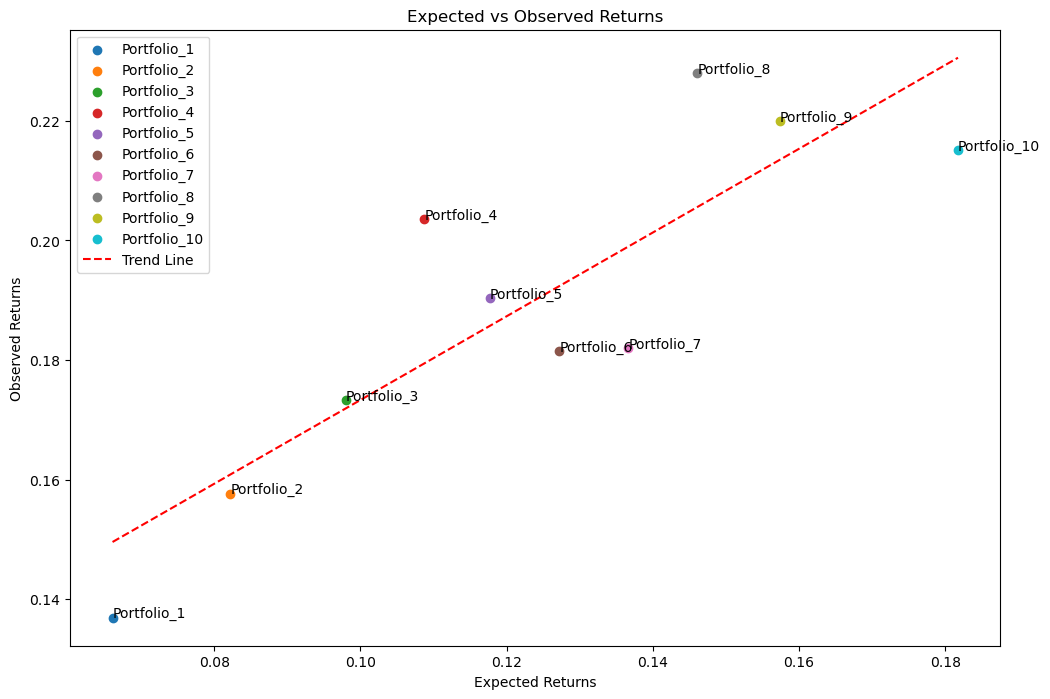

In [255]:
plot_scatter_with_trendline(df_exp_yearly_returns_1['Expected_Yearly_Return'], df_observed_returns_before['Observed_Yearly_Return'], portfolios)

While the following one is what happens after 2016

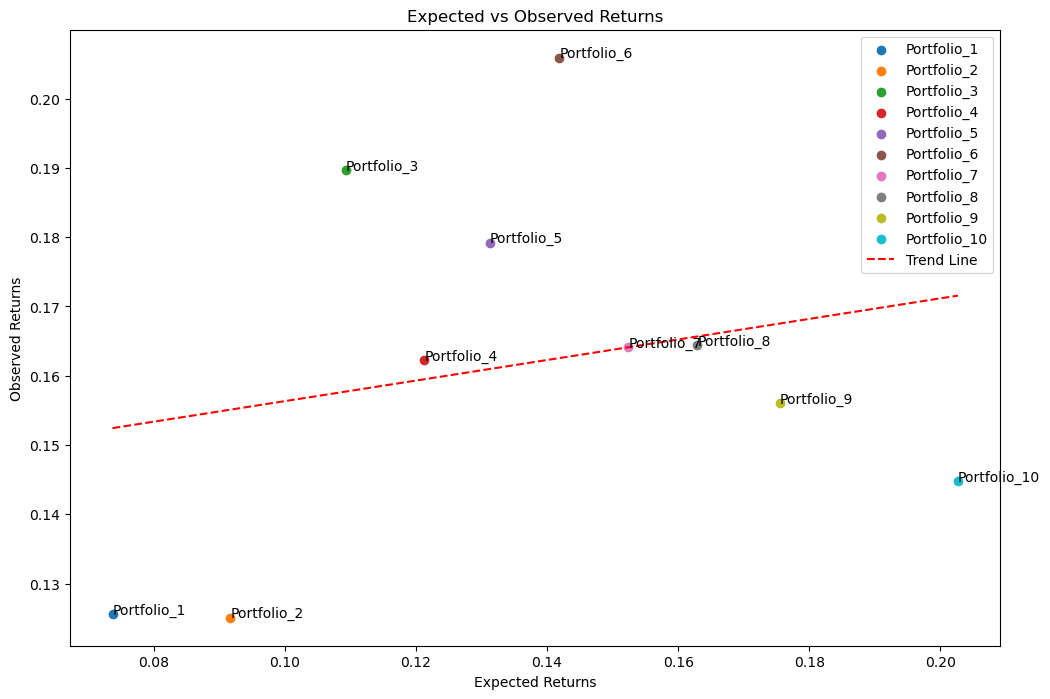

In [256]:
plot_scatter_with_trendline(df_exp_yearly_returns_2['Expected_Yearly_Return'], df_observed_returns_after['Observed_Yearly_Return'], portfolios)

The SML is too flat, meaning that the CAPM parameters are not able to explain the returns of the stocks in the considered time period!